In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve,average_precision_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import joblib

In [47]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df_sample = df.sample(n=5000, random_state=42).reset_index(drop=True)

# Optional: See the class distribution
print(df_sample['isFraud'].value_counts(normalize=True))
df_sample.head()

isFraud
0    0.998
1    0.002
Name: proportion, dtype: float64


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


In [48]:
 #checking for missing value & target distribution

print(df.isnull().sum()) 
print(df['isFraud'].value_counts(normalize=True))

x=df_sample.drop('isFraud', axis=1)  
y= df_sample['isFraud']

categorical_cols = x.select_dtypes(include='object').columns.tolist()
numerical_cols = x.select_dtypes(exclude='object').columns.tolist()
print("categorial:", categorical_cols)
print("Numerical:", numerical_cols)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64
categorial: ['type', 'nameOrig', 'nameDest']
Numerical: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']


In [49]:
# preprocessing pipeline

numerical_transform = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler()) ])
categorical_transform = Pipeline([ ('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('encoder' , OneHotEncoder(handle_unknown='ignore')) ])

preprocessor = ColumnTransformer([('num', numerical_transform, numerical_cols),
                                ('cat', categorical_transform,categorical_cols) ])

x_preprocessed = preprocessor.fit_transform(x)

In [50]:
#spliting the data
x_train, x_test, y_train, y_test = train_test_split( x,y, test_size=0.2, 
                                                    stratify=y, random_state=42)

In [53]:
#logistic Regression

lr_pipeline = Pipeline([ ('preprocess' ,preprocessor), ('clf', LogisticRegression(class_weight='balanced',max_iter=1000)) ])

lr_params = {
    'clf__C': [0.01, 0.1,1,10]
} 

lr_search = RandomizedSearchCV(lr_pipeline,
                               lr_params,
                               n_iter=4,
                               scoring='average_precision', 
                               n_jobs=-1,
                               cv=3, 
                               verbose=2) 
lr_search.fit(x_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['step',
                                                                                'amount',
                                                                                'oldbalanceOrg',
                                                                                'newbalanceOrig',
                                                                                'oldbalanceDest',
                                                                                'newbalanceDest',
                                                                                'isFlaggedFraud']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['type',
                                                                                'nameOrig',
                                                                                'nameDest'])])),
                                             ('clf',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000))]),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'clf__C': [0.01, 0.1, 1, 10]},
                   scoring='average_precision', verbose=2)

In [54]:
#Random Forest

rf_pipeline = Pipeline([ ('preprocess', preprocessor), 
                        ('clf', RandomForestClassifier(class_weight='balanced',
                         n_jobs=-1, random_state=42)) ])

rf_params = { 'clf__n_estimators': [50,100], 'clf__max_depth': [4,8,16],
             'clf__min_samples_split': [2,5] }
rf_search = RandomizedSearchCV(rf_pipeline, rf_params,n_iter=6,
                               scoring='average_precision',
                               n_jobs=-1, cv=3, verbose=2, random_state=42)
rf_search.fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['step',
                                                                                'amount',
                                                                                'oldbalanceOrg',
                                                                                'newbalanceOrig',
                                                                                'oldbalanceDest',
                                                                                'newbalanceDest',
                                                                                'isFlaggedFraud']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strat...
                                                                                               ('encoder',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['type',
                                                                                'nameOrig',
                                                                                'nameDest'])])),
                                             ('clf',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'clf__max_depth': [4, 8, 16],
                                        'clf__min_samples_split': [2, 5],
                                        'clf__n_estimators': [50, 100]},
                   random_state=42, scoring='average_precision', verbose=2)

In [55]:
#xgboost

xgb_pipeline = Pipeline([ ('preprocess', preprocessor),
                         ('clf', XGBClassifier(scale_pos_weight= (y_train == 0).sum()/(y_train == 1).sum()
                                               if(y_train == 1).sum() != 0 else 1,
                                               n_jobs=-1,
                                               use_label_encoder=False,
                                               eval_metric= 'logloss',
                                               random_state=42)) ])

xgb_params = { 'clf__n_estimators': [50,100],
               'clf__max_depth': [3,6,10],
               'clf__learing-rate': [0.01,0.1]
             }

xgb_search = RandomizedSearchCV(xgb_pipeline, xgb_params, n_iter=6, 
                                scoring='average_precision',
                                n_jobs=-1, cv=3, verbose=2, random_state=42)

xgb_search.fit(x_train,y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:03:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "learing-rate", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['step',
                                                                                'amount',
                                                                                'oldbalanceOrg',
                                                                                'newbalanceOrig',
                                                                                'oldbalanceDest',
                                                                                'newbalanceDest',
                                                                                'isFlaggedFraud']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strat...
                                                            max_depth=None,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=-1,
                                                            num_parallel_tree=None, ...))]),
                   n_iter=6, n_jobs=-1,
                   param_distributions={'clf__learing-rate': [0.01, 0.1],
                                        'clf__max_depth': [3, 6, 10],
                                        'clf__n_estimators': [50, 100]},
                   random_state=42, scoring='average_precision', verbose=2)

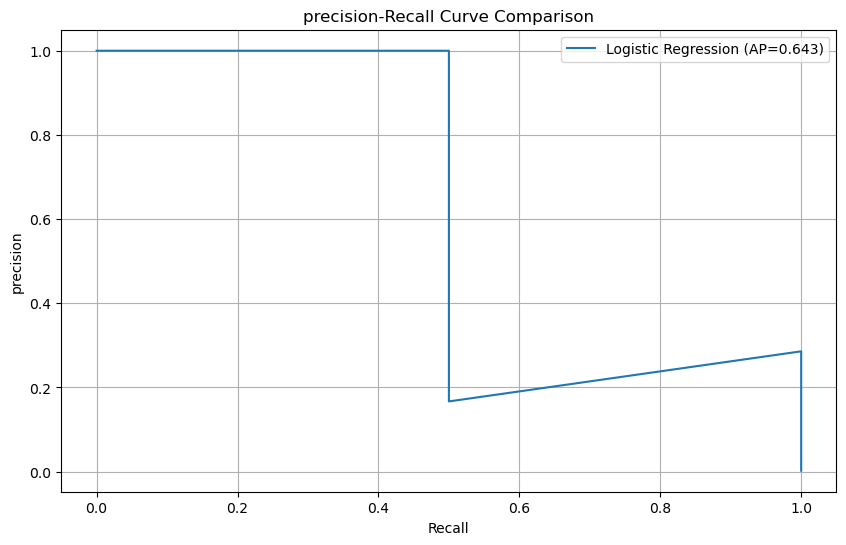

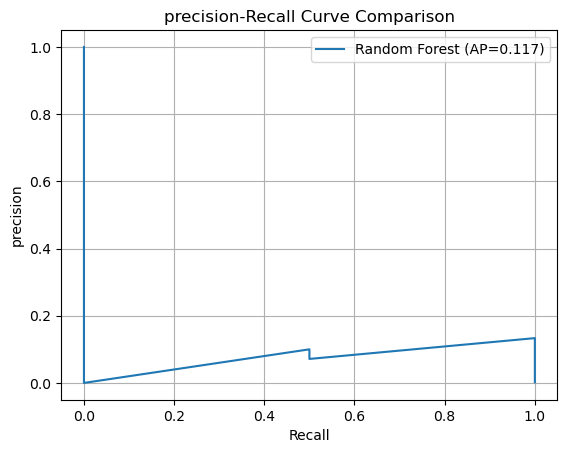

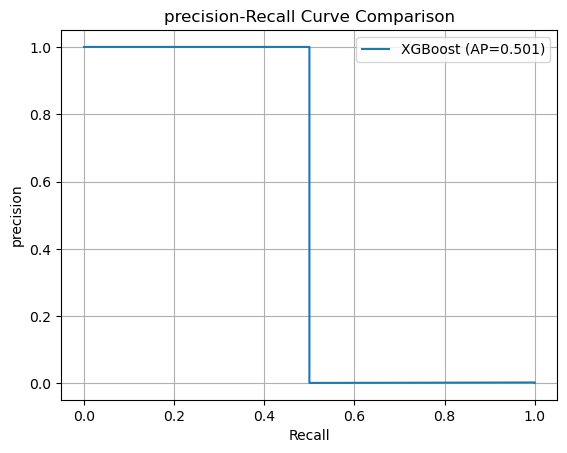

In [56]:
#compare models with precision - recall curve

plt.figure(figsize=(10,6))

for name, search in zip(['Logistic Regression', 'Random Forest', 'XGBoost'],
                        [lr_search, rf_search, xgb_search]):

    y_proba = search.predict_proba(x_test) [:, 1]
    precision, recall, _ = precision_recall_curve(y_test,y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    plt.plot(recall,precision,label=f"{name} (AP={avg_prec:.3f})")

    plt.xlabel('Recall')
    plt.ylabel('precision')
    plt.legend()
    plt.title('precision-Recall Curve Comparison')
    plt.grid()
    plt.show()
                        

In [61]:
#Compare average precision score

result = { 'Logistic Regression': average_precision_score
          (y_test, lr_search.predict_proba(x_test) [:,1]),
          'Random Forest': average_precision_score
          (y_test, rf_search.predict_proba(x_test) [:,1]),
          'XGBoost': average_precision_score
          (y_test,xgb_search.predict_proba(x_test) [:,1])
         }
print(result)

best_model = rf_search.best_estimator_

joblib.dump(best_model, 'fraud_rf_model_5K.joblib')
print("Best model exported as 'fraud_rf_model_5K.joblib'")


best_model_name = max(results, key=results.get)

model_map = {
    'Logistic Regression': lr_search.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'XGBoost': xgb_search.best_estimator_
}

best_model = model_map[best_model_name]
print(f"Best model: {best_model_name}")


{'Logistic Regression': np.float64(0.6428571428571428), 'Random Forest': np.float64(0.11666666666666667), 'XGBoost': np.float64(0.5013869625520111)}
Best model exported as 'fraud_rf_model_5K.joblib'
Best model: Logistic Regression


In [43]:
#Classification report

y_pred = best_model.predict(x_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.998     1.000     0.999       599
           1      0.000     0.000     0.000         1

    accuracy                          0.998       600
   macro avg      0.499     0.500     0.500       600
weighted avg      0.997     0.998     0.998       600



C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
